# **Cataract Eye Prediction using CNN Model**

### Made by:
* Rendy Ananta Kristanto (M239B4KY3748)
* Ryan Krishandi Lukito (M008B4KY3984)
* Leif Sean Kusumo (M239B4KY2262)
```
Resource: https://www.kaggle.com/datasets/nandanp6/cataract-image-dataset

Resource (My own drive to extract the data): https://drive.google.com/drive/folders/1pvYAlszXocWbbZiW7kigFqJQwHEmxcrz?hl=ID
```

##Data and Resource Preparation

In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==2.15.0

!pip uninstall keras
!pip install keras==2.15.0

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.15.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-2.15.0
  Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.4 kB)
Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.

Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/keras-2.15.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/keras/*
Proceed (Y/n)? ERROR: Operation cancelled by user


In [ ]:
import os
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_DIR = '/content/drive/MyDrive/datasetCapstone'

data_dir_trainval_cataract = os.path.join(DATA_DIR, 'train_validation/cataract')
data_dir_test_cataract = os.path.join(DATA_DIR, 'test/cataract')
data_dir_trainval_normal = os.path.join(DATA_DIR, 'train_validation/normal')
data_dir_test_normal = os.path.join(DATA_DIR, 'test/normal')

print(f"There are {len(os.listdir(data_dir_trainval_cataract)) + len(os.listdir(data_dir_test_cataract))} images of cataract.")
print(f"There are {len(os.listdir(data_dir_trainval_normal)) + len(os.listdir(data_dir_test_normal))} images of normal.")

There are 318 images of cataract.
There are 315 images of normal.


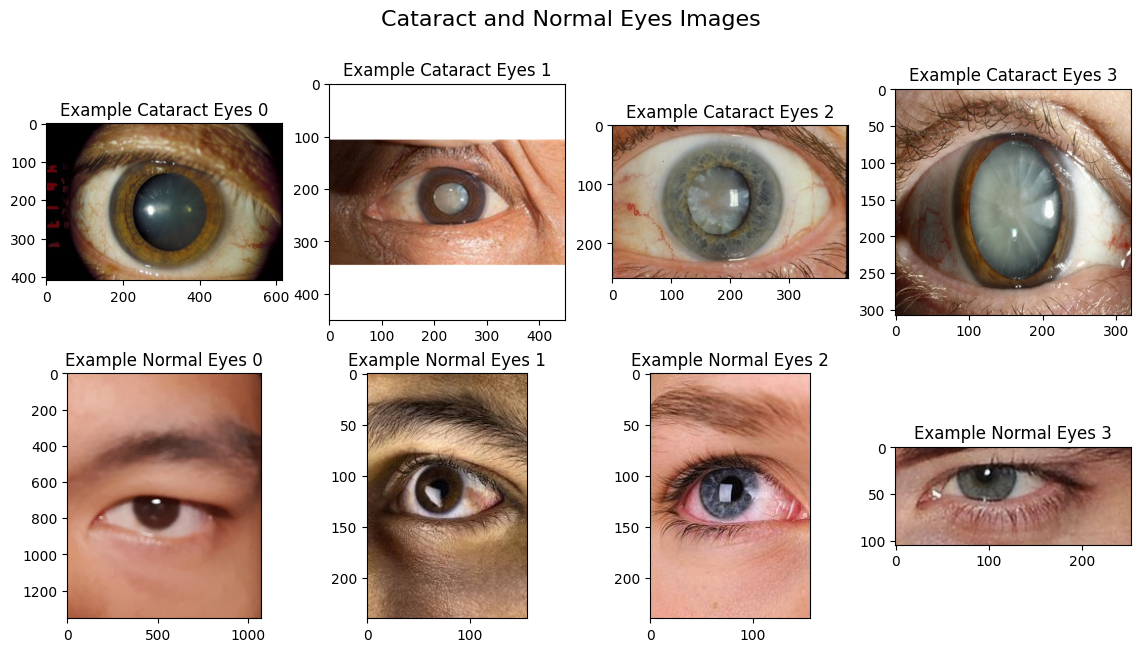

In [ ]:
cataract_filenames = [os.path.join(data_dir_trainval_cataract, filename) for filename in os.listdir(data_dir_trainval_cataract)]
normal_filenames = [os.path.join(data_dir_trainval_normal, filename) for filename in os.listdir(data_dir_trainval_normal)]

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
fig.suptitle('Cataract and Normal Eyes Images', fontsize=16)

for i, cataract_image in enumerate(cataract_filenames[:4]):
    img = tf.keras.utils.load_img(cataract_image)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Example Cataract Eyes {i}')

for i, normal_image in enumerate(normal_filenames[:4]):
    img = tf.keras.utils.load_img(normal_image)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Example Normal Eyes {i}')

plt.show()

## Training

In [ ]:
def train_val_test_datasets():
    # Training and validation datasets
    training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=os.path.join(DATA_DIR, 'train_validation'),
        image_size=(120, 120),
        batch_size=64,
        label_mode='binary',
        validation_split=0.15,
        subset='both',
        seed=42
    )

    # Test dataset
    test_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=os.path.join(DATA_DIR, 'test'),
        image_size=(120, 120),
        batch_size=64,
        label_mode='binary',
        seed=42
    )

    return training_dataset, validation_dataset, test_dataset


In [ ]:
training_dataset, validation_dataset, test_dataset = train_val_test_datasets()

Found 510 files belonging to 2 classes.
Using 434 files for training.
Using 76 files for validation.
Found 123 files belonging to 2 classes.


In [ ]:
for images, labels in training_dataset.take(1):
	example_batch_images = images
	example_batch_labels = labels

print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

Maximum pixel value of images: 255.0

Shape of batch of images: (64, 120, 120, 3)
Shape of batch of labels: (64, 1)


In [ ]:
def create_augmentation_model():

    FILL_MODE='nearest'
    augmentation_model = tf.keras.Sequential([
		tf.keras.Input(shape=(120,120,3)),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE),
        tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode=FILL_MODE),
        tf.keras.layers.RandomZoom(0.2, fill_mode=FILL_MODE)
    ])

    return augmentation_model

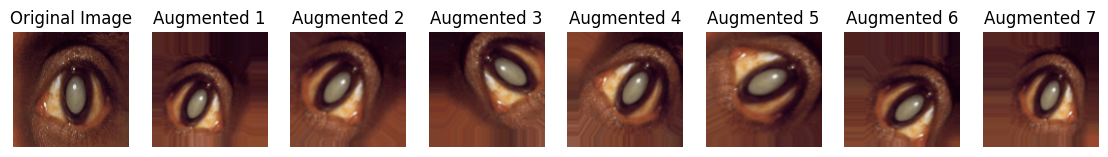

In [ ]:
data_augmentor = create_augmentation_model()

sample_image = tf.keras.utils.array_to_img(example_batch_images[0])

images = [sample_image]

for _ in range(7):
	image_aug = data_augmentor(tf.expand_dims(sample_image, axis=0))
	image_aug = tf.keras.utils.array_to_img(tf.squeeze(image_aug))
	images.append(image_aug)


fig, axs = plt.subplots(1, 8, figsize=(14, 7))
for ax, image, title in zip(axs, images, ['Original Image', 'Augmented 1', 'Augmented 2', 'Augmented 3', 'Augmented 4', 'Augmented 5', 'Augmented 6', 'Augmented 7']):
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.show()

In [ ]:
def create_model():

    augmentation_layers = create_augmentation_model()

    model = tf.keras.models.Sequential([
		    tf.keras.Input(shape=(120, 120, 3)),
        augmentation_layers,
        tf.keras.layers.Rescaling(1./255),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
model = create_model()

In [ ]:
try:
	model.evaluate(example_batch_images, example_batch_labels, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.")
else:
	predictions = model.predict(example_batch_images, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (64, 1)


In [ ]:
def calculate_parameter_count(model):
    total_params = model.count_params()
    print(f'Total number of parameters: {total_params}')
    return total_params
calculate_parameter_count(model)

Total number of parameters: 719329


719329

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 120, 120, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 120, 120, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 128)     3584      
                                                                 
 dropout (Dropout)           (None, 118, 118, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 128)       147584    
                                                      

In [ ]:
history = model.fit(
	training_dataset,
	epochs=100,
	validation_data=validation_dataset,
)

Epoch 1/100
7/7 [==============================] - 23s 945ms/step - loss: 0.7097 - accuracy: 0.4424 - val_loss: 0.6905 - val_accuracy: 0.6711
Epoch 2/100
7/7 [==============================] - 12s 490ms/step - loss: 0.6960 - accuracy: 0.5046 - val_loss: 0.6921 - val_accuracy: 0.5263
Epoch 3/100
7/7 [==============================] - 12s 358ms/step - loss: 0.6903 - accuracy: 0.5369 - val_loss: 0.6903 - val_accuracy: 0.6842
Epoch 4/100
7/7 [==============================] - 12s 352ms/step - loss: 0.6907 - accuracy: 0.5346 - val_loss: 0.6888 - val_accuracy: 0.6579
Epoch 5/100
7/7 [==============================] - 12s 348ms/step - loss: 0.6817 - accuracy: 0.5161 - val_loss: 0.6822 - val_accuracy: 0.6053
Epoch 6/100
7/7 [==============================] - 12s 355ms/step - loss: 0.6720 - accuracy: 0.5576 - val_loss: 0.6650 - val_accuracy: 0.6842
Epoch 7/100
7/7 [==============================] - 12s 555ms/step - loss: 0.6550 - accuracy: 0.6152 - val_loss: 0.6373 - val_accuracy: 0.6447
Epoch 

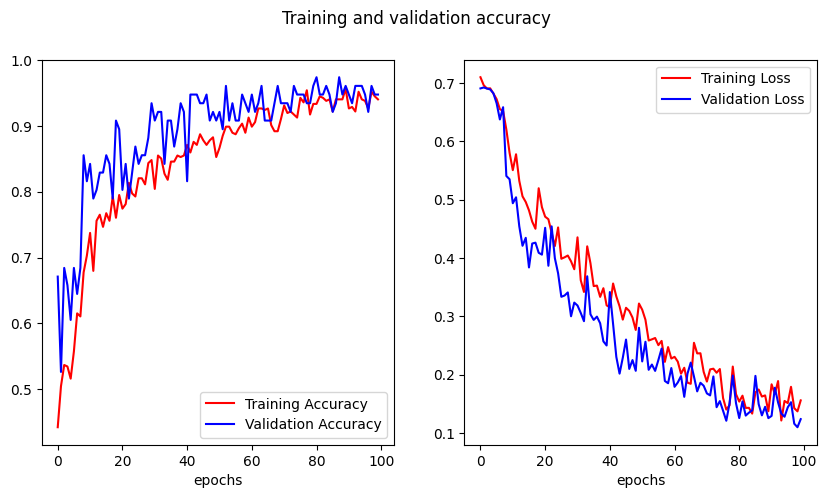

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

## Testing

In [ ]:
def predict_eye_condition(image_paths, model, threshold=0.5, output_file='prediction_results.txt'):
    results = []

    with open(output_file, 'w') as file:
      file.write("Prediction Result\n")

      for image_path in image_paths:
        img = tf.keras.utils.load_img(image_path, target_size=(120, 120))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        prediction = model.predict(img_array)[0][0]

        if 1-prediction >= threshold:
            condition = 'Cataract'
            prediction = 1 - prediction
        else:
            condition = 'Normal'

        print(f"Prediction score: {prediction:.4f}")
        print(f"The eye condition is: {condition}")

        results.append({"image_path": image_path, "condition": condition, "prediction score": prediction})
        file.write(f"{os.path.basename(image_path)}, {condition}, {prediction:.4f}\n")

    return results

In [ ]:
test_image_dir = os.path.join(DATA_DIR, 'test/cataract')
test_image_paths = [os.path.join(test_image_dir, filename) for filename in os.listdir(test_image_dir) if filename.endswith(('.png', '.jpg', '.jpeg'))]
print(predict_eye_condition(test_image_paths, model, threshold=0.5, output_file='prediction_cataract.txt'))

1/1 [==============================] - 0s 335ms/step
Prediction score: 0.9974
The eye condition is: Cataract
1/1 [==============================] - 0s 18ms/step
Prediction score: 0.9882
The eye condition is: Cataract
1/1 [==============================] - 0s 18ms/step
Prediction score: 0.9999
The eye condition is: Cataract
1/1 [==============================] - 0s 16ms/step
Prediction score: 0.9998
The eye condition is: Cataract
1/1 [==============================] - 0s 21ms/step
Prediction score: 0.9992
The eye condition is: Cataract
1/1 [==============================] - 0s 17ms/step
Prediction score: 0.9993
The eye condition is: Cataract
1/1 [==============================] - 0s 23ms/step
Prediction score: 0.9916
The eye condition is: Cataract
1/1 [==============================] - 0s 17ms/step
Prediction score: 0.9993
The eye condition is: Cataract
1/1 [==============================] - 0s 19ms/step
Prediction score: 0.9974
The eye condition is: Cataract
1/1 [======================

In [ ]:
test_image_dir = os.path.join(DATA_DIR, 'test/normal')
test_image_paths = [os.path.join(test_image_dir, filename) for filename in os.listdir(test_image_dir) if filename.endswith(('.png', '.jpg', '.jpeg'))]
print(predict_eye_condition(test_image_paths, model, threshold=0.5, output_file='prediction_normal.txt'))

1/1 [==============================] - 0s 18ms/step
Prediction score: 0.0037
The eye condition is: Normal
1/1 [==============================] - 0s 17ms/step
Prediction score: 0.1164
The eye condition is: Normal
1/1 [==============================] - 0s 25ms/step
Prediction score: 0.2277
The eye condition is: Normal
1/1 [==============================] - 0s 26ms/step
Prediction score: 0.0008
The eye condition is: Normal
1/1 [==============================] - 0s 31ms/step
Prediction score: 0.0741
The eye condition is: Normal
1/1 [==============================] - 0s 27ms/step
Prediction score: 0.2828
The eye condition is: Normal
1/1 [==============================] - 0s 24ms/step
Prediction score: 0.1250
The eye condition is: Normal
1/1 [==============================] - 0s 23ms/step
Prediction score: 0.0157
The eye condition is: Normal
1/1 [==============================] - 0s 24ms/step
Prediction score: 0.0380
The eye condition is: Normal
1/1 [==============================] - 0s 33ms

In [ ]:
model.save("model.h5", save_format="h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
